In [1]:
# --- 1. Setup and Imports ---
import torch
import os
import pandas as pd
import re
from datetime import datetime, timedelta
from newsapi import NewsApiClient
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel

# Add project root to path to allow importing 'src'
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_ingestion.scraper import get_stock_data

# Ensure CUDA is available
if not torch.cuda.is_available():
    raise SystemError("CUDA is not available. This script requires a GPU.")
print(f"CUDA available: {torch.cuda.is_available()}. Using GPU: {torch.cuda.get_device_name(0)}")

CUDA available: True. Using GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [2]:
# --- 2. Configuration ---
BASE_MODEL_ID = "chuanli11/Llama-3.2-3B-Instruct-uncensored"

# --- Paths to your two fine-tuned LoRA adapters ---
TIMESERIES_ADAPTER_PATH = os.path.join(
    project_root, "models", "processed", "chuanli11_Llama-3.2-3B-Instruct-uncensored-timeseries-v1", "final_model"
)
SENTIMENT_ADAPTER_PATH = os.path.join(
    project_root, "models", "processed", "chuanli11_Llama-3.2-3B-Instruct-uncensored-sentiment-v1", "final_model"
)

# --- Stock to analyze for this test ---
TICKER_TO_TEST = "NVDA"
YFINANCE_LINK = f"https://finance.yahoo.com/quote/{TICKER_TO_TEST}"

# News API key (load from your .env file)
NEWS_API_KEY = "YOUR_API_KEY_HERE"

In [3]:
# --- 3. Load Base Model and Attach Both Adapters ---

# QLoRA configuration using bitsandbytes
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# Load the base model
model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    low_cpu_mem_usage=True,
)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_ID)

# --- Attach the first adapter (Time Series) ---
print(f"Loading Time Series adapter from: {TIMESERIES_ADAPTER_PATH}")
model = PeftModel.from_pretrained(model, TIMESERIES_ADAPTER_PATH, adapter_name="timeseries")

# --- Attach the second adapter (Sentiment) ---
print(f"Loading Sentiment adapter from: {SENTIMENT_ADAPTER_PATH}")
model = PeftModel.from_pretrained(model, SENTIMENT_ADAPTER_PATH, adapter_name="sentiment")

print("Base model loaded with both 'timeseries' and 'sentiment' adapters.")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading Time Series adapter from: /home/anonion/ftmodel/models/processed/chuanli11_Llama-3.2-3B-Instruct-uncensored-timeseries-v1/final_model
Loading Sentiment adapter from: /home/anonion/ftmodel/models/processed/chuanli11_Llama-3.2-3B-Instruct-uncensored-sentiment-v1/final_model


/home/anonion/ftmodel/.vnv/lib/python3.12/site-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Base model loaded with both 'timeseries' and 'sentiment' adapters.


/home/anonion/ftmodel/.vnv/lib/python3.12/site-packages/peft/peft_model.py:585: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.base_model.model.model.layers.0.self_attn.q_proj.lora_A.sentiment.weight', 'base_model.model.base_model.model.model.layers.0.self_attn.q_proj.lora_B.sentiment.weight', 'base_model.model.base_model.model.model.layers.0.self_attn.k_proj.lora_A.sentiment.weight', 'base_model.model.base_model.model.model.layers.0.self_attn.k_proj.lora_B.sentiment.weight', 'base_model.model.base_model.model.model.layers.0.self_attn.v_proj.lora_A.sentiment.weight', 'base_model.model.base_model.model.model.layers.0.self_attn.v_proj.lora_B.sentiment.weight', 'base_model.model.base_model.model.model.layers.0.self_attn.o_proj.lora_A.sentiment.weight', 'base_model.model.base_model.model.model.layers.0.self_attn.o_proj.lora_B.sentiment.weight', 'base_model.model.base_model.model.model.layers.0.mlp.gate_proj.lora_A.sentiment.weight', 'base_model.mod

In [4]:
# --- 4. Instance 1 - Run Time Series Forecast ---

# --- A. Get latest data and find volatility ---
df_stock = get_stock_data(yfinance_link=YFINANCE_LINK, period="3mo")
df_stock['price_change_pct'] = df_stock['Close'].pct_change().abs() * 100
high_thresh = df_stock['price_change_pct'].quantile(0.75)
df_stock['is_volatile'] = df_stock['price_change_pct'] >= high_thresh
volatile_dates = df_stock[df_stock['is_volatile']]['Date'].tolist()

# --- B. Create the prompt for inference ---
context_days = 60
context_prices = df_stock['Close'][-context_days:].tolist()
context_str = ", ".join([f"{p:.2f}" for p in context_prices])
mean = df_stock['Close'][-context_days:].mean()
std_dev = df_stock['Close'][-context_days:].std()
trend = "upward" if context_prices[-1] > context_prices[0] else "downward"

inference_prompt = f"""<|begin_of_text|><|start_header_id|>user<|end_header_id|>
TASK: Time Series Forecast.
STOCK: {TICKER_TO_TEST}
STATISTICS: mean={mean:.2f}, std_dev={std_dev:.2f}, trend={trend}
CONTEXT_DAYS: {context_days}
DATA: [{context_str}]
Predict the next 5 closing prices.<|eot_id|><|start_header_id|>assistant<|end_header_id|>
PREDICTION:"""

# --- C. Generate the forecast ---
model.set_adapter("timeseries") # Activate the timeseries adapter
inputs = tokenizer(inference_prompt, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=50, pad_token_id=tokenizer.eos_token_id)
forecast_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

# --- D. Parse the output ---
try:
    forecast_str = forecast_text.split("PREDICTION:")[1]
    price_forecast = [float(p.strip()) for p in re.findall(r'[\d\.]+', forecast_str)]
    print(f"Price Forecast for next 5 days: {price_forecast}")
except Exception as e:
    price_forecast = "Could not parse forecast."
    print(f"Error parsing forecast: {e}\nRaw output: {forecast_text}")

Starting data ingestion for link: https://finance.yahoo.com/quote/NVDA
Extracted ticker: NVDA
Successfully scraped 64 data points.
Minor preprocessing complete. (Date formatting, 20-day MA calculated)
Data temporarily saved to: data/processed/NVDA_processed_data.csv
Price Forecast for next 5 days: [177.98, 179.8, 181.76, 181.59, 180.16]


In [5]:
# --- 5. Instance 2 - Run Sentiment Analysis ---

# --- A. Fetch news based on volatility ---
newsapi = NewsApiClient(api_key=NEWS_API_KEY)
headlines_to_analyze = []
# Analyze news from the last 5 trading days
for date_str in df_stock['Date'][-5:].tolist():
    article_count = 50 if date_str in volatile_dates else 10 # More articles on volatile days
    try:
        articles = newsapi.get_everything(q=TICKER_TO_TEST, from_param=date_str, to=date_str, language='en', sort_by='relevancy', page_size=article_count)
        for article in articles['articles']:
            headlines_to_analyze.append(article['title'])
    except Exception:
        continue # Ignore days with no news

# --- B. Analyze headlines ---
model.set_adapter("sentiment") # Activate the sentiment adapter
sentiment_results = []
for headline in headlines_to_analyze:
    inference_prompt = f"""<|begin_of_text|><|start_header_id|>user<|end_header_id|>
Analyze the following financial headline. Provide its sentiment score from -1.0 to 1.0 and predict the stock's percentage change for the next trading day.
HEADLINE: {headline}<|eot_id|><|start_header_id|>assistant<|end_header_id|>"""
    
    inputs = tokenizer(inference_prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=50, pad_token_id=tokenizer.eos_token_id)
    analysis_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    sentiment_results.append(analysis_text)
    
print("Sentiment analysis complete.")
# Print a few examples
for result in sentiment_results[:3]:
    print(result.split("<|start_header_id|>assistant<|end_header_id|>")[1].strip())
    print("-" * 20)

Sentiment analysis complete.


In [6]:
# --- 6. Instance 3 - Generate Final Report ---
print('debug statement1')
model.disable_adapter() # Use the base Llama 3 model's general capabilities
print('debug statement2')
# --- A. Consolidate all gathered information ---
info_for_report = f"""
Price Forecast for {TICKER_TO_TEST} (next 5 days): {price_forecast}

Recent News Analysis:
"""
print('debug statement3')
for result in sentiment_results:
    # Append the assistant's response part of the analysis
    info_for_report += f"- {result.split('<|start_header_id|>assistant<|end_header_id|>')[1].strip()}\n"
print('debug statement4')
# --- B. Create the final prompt ---
reporting_prompt = f"""<|begin_of_text|><|start_header_id|>user<|end_header_id|>
You are a senior financial analyst. Synthesize the following quantitative forecast and qualitative news analysis into a concise, professional report for an investor.
Do not just list the data. Provide a concluding summary of the likely outlook for the stock.

--- DATA ---
{info_for_report}
--- END DATA ---

ANALYST REPORT:<|eot_id|><|start_header_id|>assistant<|end_header_id|>
"""
print('debug statement5')
## --- C. Generate the report (Corrected Version) ---
inputs = tokenizer(reporting_prompt, return_tensors="pt").to("cuda")

# Get the length of the prompt tokens
input_token_length = inputs.input_ids.shape[1]

# Generate the output
outputs = model.generate(**inputs, max_new_tokens=512, pad_token_id=tokenizer.eos_token_id)

# --- Decode only the newly generated tokens ---
# Slice the output to remove the original prompt tokens
generated_tokens = outputs[0, input_token_length:]
final_report_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)


print("--- FINAL ANALYST REPORT ---")
print(final_report_text.strip())

debug statement1
debug statement2
debug statement3
debug statement4
debug statement5
--- FINAL ANALYST REPORT ---
**Confidential Investor Report**

**Subject: NVDA Stock Outlook**

**Executive Summary**

We have analyzed the recent quantitative forecast and qualitative news analysis regarding NVIDIA Corporation (NVDA). Our findings suggest a complex market environment, with both positive and negative indicators. Our technical analysis indicates a potential short-term price movement, while our qualitative analysis highlights concerns surrounding the company's regulatory landscape.

**Technical Analysis**

Our quantitative forecast suggests a volatile price trajectory for NVDA over the next 5 days, with a range of $177.98 to $180.16. This range is indicative of a potential short-term price movement, which may be influenced by external factors. We cannot rule out the possibility of a price drop, given the current market conditions.

**Qualitative Analysis**

Recent news regarding regulato

Forecast successful. Generating plot...


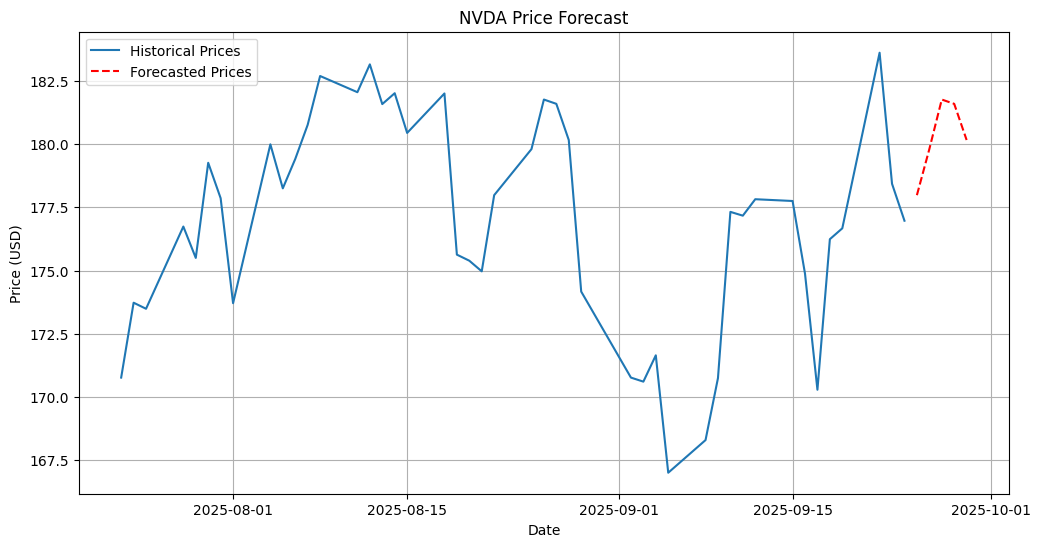

In [7]:
# --- 7. Visualization (Robust Version) ---
import matplotlib.pyplot as plt
import numbers # A helper to check for numbers

# --- Check if the forecast was successful before plotting ---
if isinstance(price_forecast, list) and all(isinstance(p, numbers.Number) for p in price_forecast):
    print("Forecast successful. Generating plot...")
    
    # Create future dates for the forecast
    last_date = pd.to_datetime(df_stock['Date'].iloc[-1])
    forecast_dates = [last_date + timedelta(days=i) for i in range(1, len(price_forecast) + 1)]

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(pd.to_datetime(df_stock['Date'][-60:]), df_stock['Close'][-60:], label="Historical Prices")
    plt.plot(forecast_dates, price_forecast, label="Forecasted Prices", color='red', linestyle='--')
    plt.title(f"{TICKER_TO_TEST} Price Forecast")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("\n--- Plotting Skipped ---")
    print("Forecast failed or could not be parsed, so no plot will be generated.")
    print(f"Content of 'price_forecast' variable: {price_forecast}")